In [190]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [191]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [192]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [193]:
model.find_ss(0.50,do_print=True)

ss.S = 7.44
ss.L = 56.28
ss.delta_L = 0.07
ss.v = 16.52
ss.m_v = 0.23
ss.r_K = 0.14
ss.r_ell = 1.68
ss.r_E = 1.00
ss.ell = 55.87
ss.w = 1.66
ss.K = 85.47
ss.I = 8.55
ss.Y = 158.78
ss.G = 39.69
ss.B_G = 0.00
ss.tau = 0.44
solving for household behavior: result.converged = True
ss.C = 48.80
ss.B = -9.09
ss.X = 160.31
ss.M = 151.48
par.phi = 0.944


**Household behavior:**

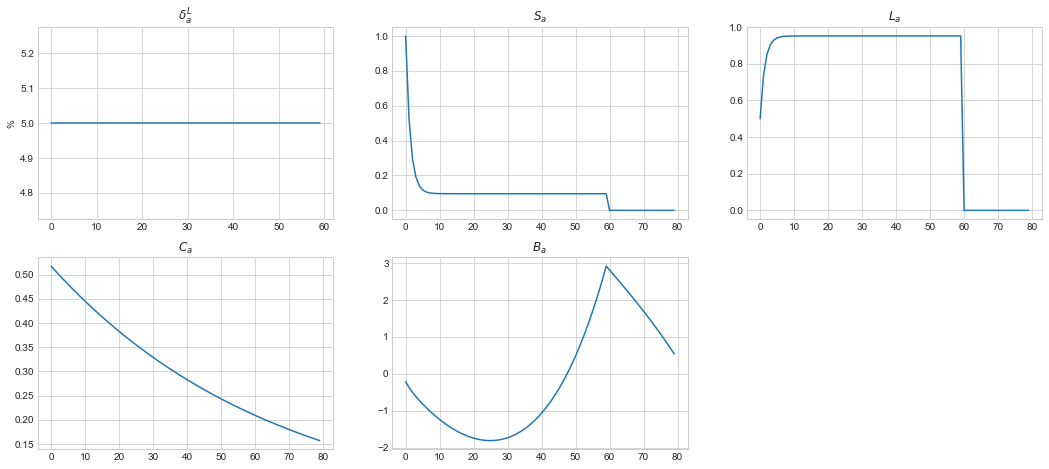

In [194]:
fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(3,3,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(3,3,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$');

# Speed and error tests

In [195]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [196]:
%time model.evaluate_blocks(py=True)

CPU times: user 3.97 s, sys: 56.6 ms, total: 4.03 s
Wall time: 4.18 s


**Check errors:**

In [197]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 6.66e-16
Bq_match            : abs. max = 4.53e-12
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 6.66e-16
FOC_E_Y_KL          : abs. max = 1.67e-16
mkt_clearing        : abs. max = 0.00e+00
repacking_prices_C  : abs. max = 0.00e+00


In [198]:
sol.E

array([52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92666507,
       52.92666507, 52.92666507, 52.92666507, 52.92666507, 52.92

**First numba evaluation:**

In [199]:
%time model.evaluate_blocks()

CPU times: user 59.2 s, sys: 1.31 s, total: 1min
Wall time: 1min 3s


**Time:**

In [200]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

22.2 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
85.8 µs ± 3.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [201]:
%timeit model.evaluate_blocks(py=True)

530 ms ± 5.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Find an impulse-response

**Calculate Jacobian:**

In [202]:
model.calc_jac(do_print=True)

Jacobian calculated in 45.7 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [203]:
model.set_exo_ss()

**Shock function:**

In [204]:
def shock_func_ny(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8):
        shock_f = shock_size
        persistence_f = persistence_size ** np.arange(time_span)
        solvalue[time_start:time_start+time_span] = ssvalue + shock_f*persistence_f

In [205]:
Tshock = 50
shock = 0.2*ss.r_E
persistence = 0.85**np.arange(Tshock)
sol.r_E[:Tshock] = ss.r_E + shock*persistence

In [206]:
# Tshock = 20
# a = 0.1
# b = 10
# c = 4

# shock_t = np.zeros(Tshock)
# for i in range(Tshock):
    # shock_t[i] = ss.P_E + a/(1+b*(i-c)**2)
# sol.P_E[10:10+Tshock] = shock_t

Check errors when guessing at steady state -> excess demand

In [207]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 1.11e-15
Bq_match            : abs. max = 1.77e+00
FOC_capital_agency  : abs. max = 1.04e-02
FOC_K_ell           : abs. max = 6.66e-16
FOC_E_Y_KL          : abs. max = 7.02e-02
mkt_clearing        : abs. max = 1.52e+01
repacking_prices_C  : abs. max = 4.86e-02


**Find IRF:**

In [208]:
model.find_IRF()

initial:
   max. abs. error = 1.52e+01
    1.11e-15 in bargaining_cond
    1.77e+00 in Bq_match
    1.04e-02 in FOC_capital_agency
    6.66e-16 in FOC_K_ell
    7.02e-02 in FOC_E_Y_KL
    1.52e+01 in mkt_clearing
    4.86e-02 in repacking_prices_C

it = 0
 solve: t1-t0 = 1.2 secs
   max. abs. error = 1.52e+01
    2.85e-03 in bargaining_cond
    3.60e-02 in Bq_match
    1.53e-03 in FOC_capital_agency
    1.63e-03 in FOC_K_ell
    3.23e-03 in FOC_E_Y_KL
    1.24e-01 in mkt_clearing
    5.01e-04 in repacking_prices_C
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.1 secs

it = 1
 solve: t1-t0 = 1.2 secs
   max. abs. error = 1.24e-01
    7.60e-04 in bargaining_cond
    2.79e-03 in Bq_match
    3.77e-05 in FOC_capital_agency
    3.11e-04 in FOC_K_ell
    3.47e-04 in FOC_E_Y_KL
    1.36e-01 in mkt_clearing
    2.54e-04 in repacking_prices_C
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.1 secs

it = 2
 solve: t1-t0 = 1.1 secs
   max. abs. error = 1.36e-01
    2.25e-04 in bargaining_co

**Plot:**

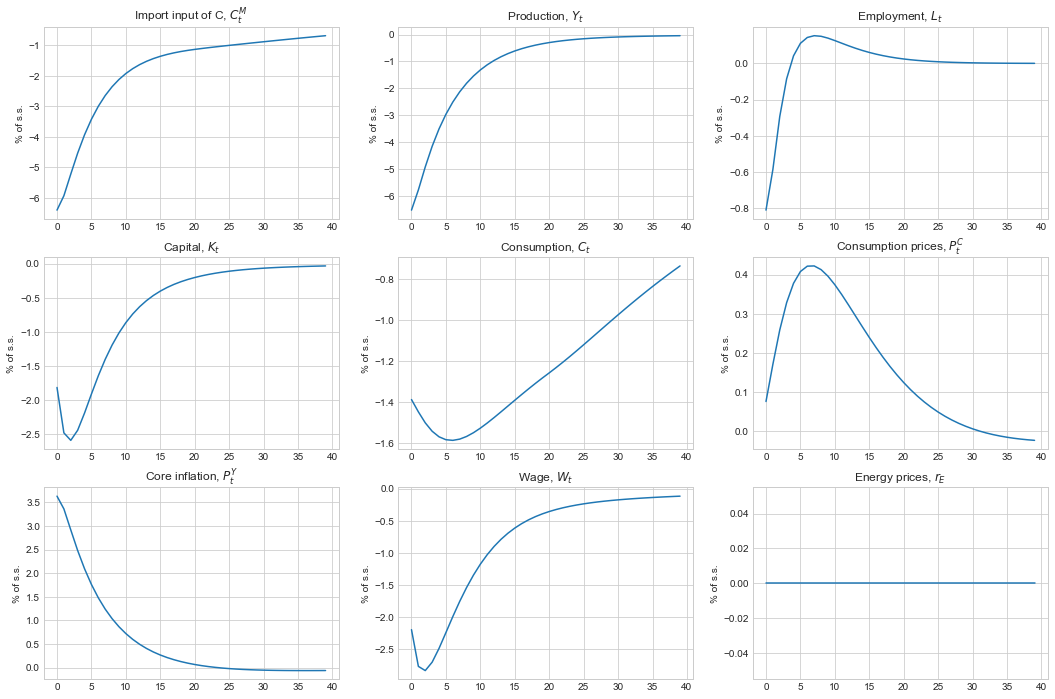

In [209]:
T_IRF = 40

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot((sol.C_Y[:T_IRF]/ss.C_Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Import input of C, $C^M_t$')

ax = fig.add_subplot(3,3,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,3,3)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(3,3,4)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,3,5)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,3,6)
ax.plot(((sol.P_C[:T_IRF])/(ss.P_C)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption prices, $P^C_t$');

ax = fig.add_subplot(3,3,7)
ax.plot(((sol.P_Y[:T_IRF])/(ss.P_Y)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Core inflation, $P^{Y}_t$');

ax = fig.add_subplot(3,3,8)
ax.plot(((sol.w[:T_IRF])/(ss.w)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Wage, $W_t$');

ax = fig.add_subplot(3,3,9)
ax.plot(((sol.P_E[:T_IRF])/(ss.P_E)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Energy prices, $r_E$');